In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from io import BytesIO

load data from site

In [2]:
url = "https://www.mibici.net/es/datos-abiertos/"

#header that mimics actual web browser bc i was getting response 406
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/118.0 Safari/537.36"
    ),
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
}

page = requests.get(url,headers=headers)
page #response 200 means OK                         

<Response [200]>

In [3]:
soup = BeautifulSoup(page.text,'html') #get html from webpage
soup

<!DOCTYPE html>

<html lang="es">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width,initial-scale=1" name="viewport"/>
<meta content="INDEX,FOLLOW" name="robots">
<title>Mi Bici | Datos abiertos</title>
<meta content="Explora, experimenta y comparte los datos de uso de Mi Bici." name="description"/>
<link href="https://www.mibici.net/es/datos-abiertos/" rel="canonical"/>
<meta content="MiBici |Datos abiertos" property="og:title"/>
<meta content="Explora, experimenta y comparte los datos de uso de Mi Bici." property="og:description"/>
<meta content="https://www.mibici.net/site/templates/assets/images/og-meta-image.jpg" property="og:image"/>
<meta content="image/jpeg" property="og:image:type"/>
<meta content="960" property="og:image:width"/>
<meta content="540" property="og:image:height"/>
<meta content="website" property="og:type"/>
<meta content="Mi Bici" property="og:site_name"/>
<meta content="https://www.mibici.ne

In [4]:
soup.find_all('a') #all links have tag = <a>

[<a href="/">
 <img alt="Mi Bici" class="logo" src="/site/templates/assets/images/logo-mibici-obscuro.svg"/>
 </a>,
 <a href="/es/mapa/" title="Mapa">
                   Mapa                </a>,
 <a href="/es/preguntas-frecuentes/" title="Preguntas frecuentes">
                  Preguntas frecuentes               </a>,
 <a href="/es/como-funciona/" title="¿Cómo funciona?">
                  ¿Cómo funciona?               </a>,
 <a href="/es/contacto/" rel="noreferrer" title="Contacto">
                  Contacto               </a>,
 <a href="/es/iniciar-sesion/" rel="noreferrer" title="Iniciar Sesión">
 <button class="btn-outline">Iniciar Sesión</button>
 </a>,
 <a href="/es/registro/" rel="noreferrer" title="Registro">
 <button name="button" type="button">
                    Suscríbete                 </button>
 </a>,
 <a href="/es/iniciar-sesion/" rel="noreferrer" title="Iniciar Sesión">
 <button class="btn-outline">Iniciar Sesión</button>
 </a>,
 <a href="/es/tarifas/" rel="norefer

In [5]:
links = []
for a in soup.find_all("a", href=True):
    if a["href"].startswith("/site/assets/files/") and a["href"].endswith(".csv"):
        links.append(urljoin('https://www.mibici.net/', a["href"]))
print(len(links))

133


In [6]:
#doesn't work bc server rejects request w/out right headers and pd has no fix
# dfs= []
# for link in links[1:]:#first link is nomenclature
#     df = pd.read_csv(link)
#     dfs.append(df)

In [7]:
#fix
# response = requests.get(links[2],headers=headers)
# df = pd.read_csv(BytesIO(response.content))
# df.head

In [8]:
#works but takes tooo long 
# dfs = []
# count=1
# for link in links[1:]: #first link is nomenclature file
#     response = requests.get(link,headers=headers)
#     dfs.append(pd.read_csv(BytesIO(response.content)))#BytesIO stores response in memory were pd can read
#     print("Data imported from",count," out of ",len(links),"links")
#     count+=1
# df = pd.concat(dfs) 


the data doesnt say how many bikes in the fleet or the capacity of each station. in this section i'll try to deduce the initial size of fleet upon inauguration and statio capacity upon inauguration

In [9]:
dfs = []
count=1
for link in links[1:2]: #exploratory one month
    response = requests.get(link,headers=headers)
    dfs.append(pd.read_csv(BytesIO(response.content)))#BytesIO stores response in memory were pd can read
    print("Data imported from",count," out of ",len(links),"links")
    count+=1
df = pd.concat(dfs)
df.info

Data imported from 1  out of  133 links


<bound method DataFrame.info of        Viaje_Id  Usuario_Id Genero  Año_de_nacimiento     Inicio_del_viaje  \
0          4601       10324      M                NaN  2014-12-01 00:33:47   
1          4604       10324      M                NaN  2014-12-01 01:06:54   
2          4628           3      F             1990.0  2014-12-01 09:47:20   
3          4631         102      M             1982.0  2014-12-01 09:48:23   
4          4632           3      F             1990.0  2014-12-01 09:48:46   
...         ...         ...    ...                ...                  ...   
23962     42029        1736      M             1966.0  2014-12-31 22:43:35   
23963     42030       20342      M                NaN  2014-12-31 22:49:43   
23964     42031       20342      M                NaN  2014-12-31 23:09:37   
23965     42032        1736      M             1966.0  2014-12-31 23:33:28   
23966     42033       16054      M             1976.0  2014-12-31 23:38:57   

             Fin_del_viaje  Ori

we can rule out that all stations were full upon inauguration since that wouldn't allow circulation
so lets naively count how many bikes left and arrived to each station day 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23967 entries, 0 to 23966
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Viaje_Id           23967 non-null  int64  
 1   Usuario_Id         23967 non-null  int64  
 2   Genero             23962 non-null  object 
 3   Año_de_nacimiento  23747 non-null  float64
 4   Inicio_del_viaje   23967 non-null  object 
 5   Fin_del_viaje      23967 non-null  object 
 6   Origen_Id          23967 non-null  int64  
 7   Destino_Id         23967 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 1.5+ MB


In [11]:
df.describe()

,Viaje_Id,Usuario_Id,Año_de_nacimiento,Origen_Id,Destino_Id
count,23967.000000,23967.000000,23747.000000,23967.000000,23967.000000
mean,24274.527350,8364.778988,1981.969301,47.597864,47.228523
std,10237.985577,5261.300723,9.815592,23.652728,23.422110
min,4601.000000,3.000000,1944.000000,2.000000,2.000000
25%,15860.500000,3622.000000,1977.000000,28.000000,29.000000
50%,24394.000000,7516.000000,1984.000000,50.000000,50.000000
75%,32876.500000,12749.500000,1989.000000,66.000000,66.000000
max,42033.000000,20342.000000,1998.000000,88.000000,88.000000


In [12]:
# min_origen = 2
# max_origen = 88
n_estaciones = 87
n_dias = 31




In [13]:
#format columns
df['Inicio_del_viaje'] = pd.to_datetime(df['Inicio_del_viaje'])
df['Fin_del_viaje'] = pd.to_datetime(df['Fin_del_viaje'])
df['Fin_del_viaje']

0       2014-12-01 00:36:54
1       2014-12-01 01:08:45
2       2014-12-01 09:47:47
3       2014-12-01 09:48:37
4       2014-12-01 09:48:57
                ...        
23962   2014-12-31 22:56:17
23963   2014-12-31 23:04:32
23964   2014-12-31 23:25:23
23965   2014-12-31 23:39:59
23966   2014-12-31 23:47:09
Name: Fin_del_viaje, Length: 23967, dtype: datetime64[ns]

In [14]:
eventos_inicio = df[['Inicio_del_viaje', 'Origen_Id']].rename(columns={'Inicio_del_viaje':'Momento', 'Origen_Id':'Estacion_Id'})
eventos_inicio['Delta'] = -1


In [15]:

eventos_fin = df[['Fin_del_viaje', 'Destino_Id']].rename(columns={'Fin_del_viaje':'Momento', 'Destino_Id':'Estacion_Id'})
eventos_fin['Delta'] = +1


In [16]:

eventos = pd.concat([eventos_inicio,eventos_fin]).sort_values('Momento')
eventos

,Momento,Estacion_Id,Delta
0,2014-12-01 00:33:47,47,-1
0,2014-12-01 00:36:54,47,1
1,2014-12-01 01:06:54,5,-1
1,2014-12-01 01:08:45,5,1
2,2014-12-01 09:47:20,79,-1
...,...,...,...
23964,2014-12-31 23:25:23,37,1
23965,2014-12-31 23:33:28,51,-1
23966,2014-12-31 23:38:57,14,-1
23965,2014-12-31 23:39:59,52,1


In [31]:
estaciones = eventos["Estacion_Id"].unique()
num_bicis = {}
for estacion in estaciones:
    num_bicis[estacion] = 0

In [32]:

timeline= []
for i,evento in eventos.iterrows():
    num_bicis[evento['Estacion_Id']] += evento['Delta']

    timeline.append({
        "Momento": evento["Momento"],
        "Estacion_Id": evento['Estacion_Id'],
        "Num_bicis": num_bicis[evento['Estacion_Id']] 

    })

timeline_df = pd.DataFrame(timeline)
timeline_df

,Momento,Estacion_Id,Num_bicis
0,2014-12-01 00:33:47,47,-1
1,2014-12-01 00:36:54,47,0
2,2014-12-01 01:06:54,5,-1
3,2014-12-01 01:08:45,5,0
4,2014-12-01 09:47:20,79,-1
...,...,...,...
47929,2014-12-31 23:25:23,37,51
47930,2014-12-31 23:33:28,51,-36
47931,2014-12-31 23:38:57,14,-3
47932,2014-12-31 23:39:59,52,-13


In [ ]:
# timeline_df[timeline_df.Estacion_Id == 5] #testing OK

,Momento,Estacion_Id,Num_bicis
2,2014-12-01 01:06:54,5,-1
3,2014-12-01 01:08:45,5,0
1337,2014-12-02 08:04:40,5,1
1339,2014-12-02 08:06:17,5,0
1341,2014-12-02 08:07:48,5,1
...,...,...,...
46338,2014-12-30 17:47:37,5,-5
46880,2014-12-31 08:02:24,5,-4
47462,2014-12-31 14:47:34,5,-3
47464,2014-12-31 14:49:18,5,-4


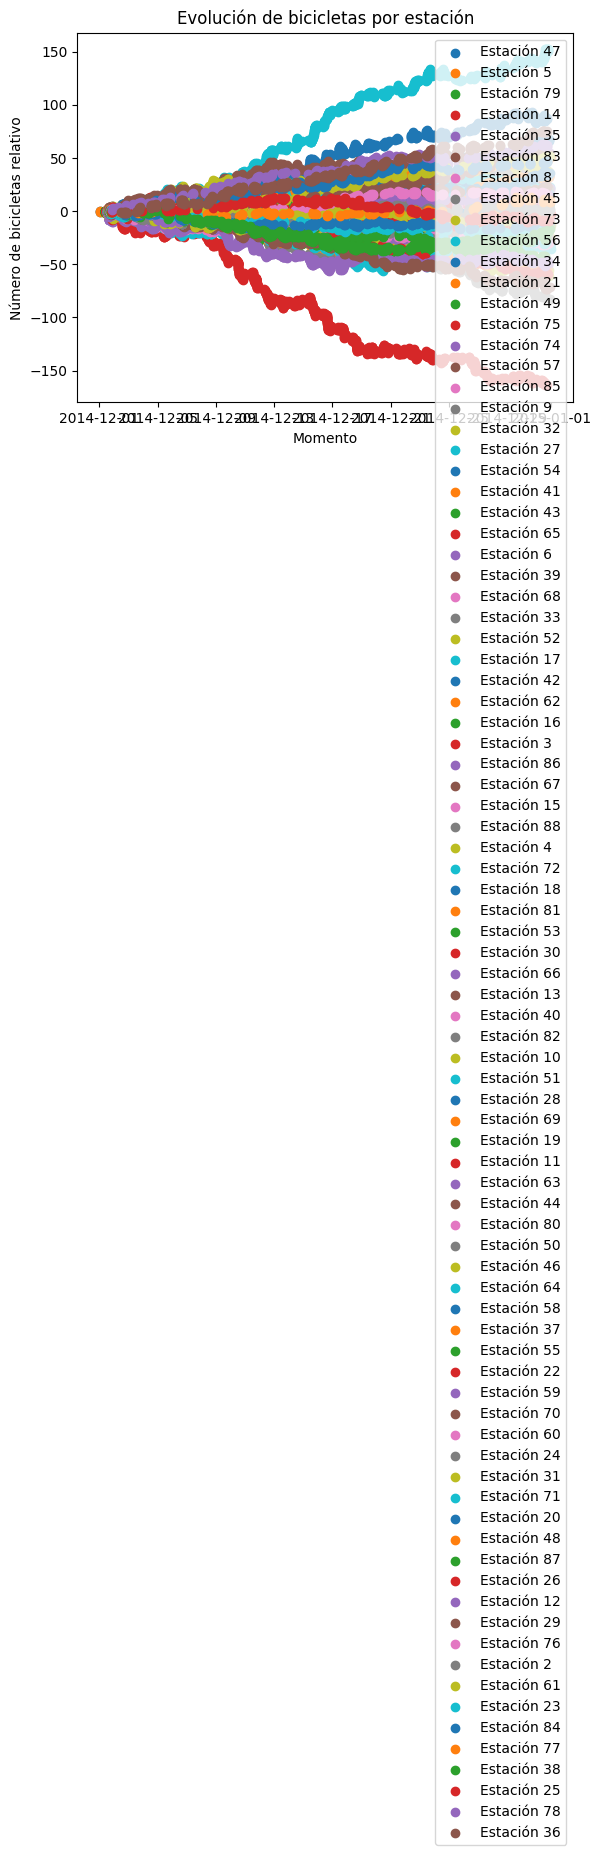

In [38]:
for estacion in timeline_df["Estacion_Id"].unique():
    datos_estacion = timeline_df[timeline_df["Estacion_Id"] == estacion]
    plt.scatter(datos_estacion["Momento"], datos_estacion["Num_bicis"], label=f"Estación {estacion}")

plt.xlabel("Momento")
plt.ylabel("Número de bicicletas relativo")
plt.title("Evolución de bicicletas por estación")
plt.legend()
plt.show()